# Confidence intervals for RI

##  Basic idea

Following the Good Book (Imbens and Rubin, ch. 5.7, pp. 74--75): 
- we observe realized outcomes $Y_i^{obs} = Y_i(T_i)$ and estimated tretment effect $\hat\tau$. For simplicity, we take this to be the test statistic about which we want to conduct RI.
- Consider a postulated treatment effect $\tau =\tau_0$, possibly nonzero. 
- Under the null that $\tau_0$ is the truth, then 
    \begin{equation}
    Y_i(0;\tau_0) = 
        \begin{cases}
        Y_i^{obs} & \text{ if } T_i = 0\\
        Y_i^{obs}-\tau_0 & \text{ if } T_i = 1 
        \end{cases}
    \end{equation}
    Here, the notation $Y_i(0;\tau_0)$ is intended to make explicit that this is the potential outcome in the absence of treatment _as imputed under the sharp null that $\tau = \tau_0$_.
- We then decide whether $\tau_0$ is within the 95 percent confidence interval for additive treatment effects, $\tau$, as follows:
    1. For permutations $r=1,\ldots,R$:
        1. draw a treatment assignment $T_r$. 
        2. impute the outomes that would be observed under this assignment and under the sharp null that $\tau=\tau_0$. These are given by
            \begin{equation}
            Y_i(T_r) = %
                \begin{cases}
                Y_i(0;\tau_0) & \text{ if } T_{i,r} = 0 \\
                Y_i(0;\tau_0) + \tau_0 & \text{ if} T_{i,r}=1
                \end{cases}
            \end{equation}
        3. use these imputed outcomes to estimate a draw of the test statistic, $\hat\tau_r$.
    2. Define $\hat{p}(\tau_0)$ as the estimated $p$-value for $\tau=\tau_0$. If the $p-$value associated with $\tau_0$ is greater than 0.05, then $\tau_0$ is in the 95 percent "Fisher" interval; otherwise, it is outside this region.

## The basic computational problem

Even if $p$-values are well behaved---in the sense that as $R\rightarrow\infty$ they become monotonically decreasing as $\tau_0$ becomes farther from the truth, for finite $R$ they are subject to sampling error (where sampling here refers to sampling from the randomization distribution, not from the population of units $i$).  

This means that for any candidate $\tau_0$, we require $R$ to be fairly large in order to ensure that, during the search process, that value $\tau_0$ lies within or outside of the 95 percent C.I.

On the other hand, in order to pin down the Fisher interval with precision, we may need to try many candidate values of $\tau_0$ until we obtain a sufficiently small interval $[\underline\tau_0,\overline\tau_0]$ such that $\hat{p}(\underline\tau_0)$ and $\hat{p}(\overline\tau_0)$ lie on alternate sides of 0.05.

## A (potentially) high-computational cost solution

An existing literature for other types of estimators has considered the question of efficiency in the construction of CIs from permutation tests.  [Ganong and J\"{a}ger (JASA 2018, Appendix C)](http://economics.mit.edu/files/13020) write
   > Relative to the existing literature, which primarily uses a grid of hypothetical effects, we implement the bisection method to find the end points of the confidence interval, which significantly improves upont the computational cost of a grid search while delivering the same level of precision.

They propose the following algorithm:

1. Identify a search region, between $[\underline{S},\overline{S}]$. "Quantitatively, we start with a search region 10 times the size of the asymptotic confidence interval and iteratively increase the search region by a factor of 10 until we have found lower and upper bounds, $\underline{S}$ and $\overline{S}$, at which the null hypothesis is rejected."

2. "Perform bisection search in each half of search region."  Splitting the search region at the point estimate, $\hat{S}$, they perform bisection search separately in the upper and lower intervals. For the interval $[\hat{S},\overline{S}]$:
    1. Perform permutation test subtracting out as hypothetical effect size the mid-point, $m$, of $[\hat{S},\overline{S}]: m=0.5\cdot(\hat{S}+\overline{S})$.
    2. Define new interval depending on the result of the permutation test at midpoint $m$:
        1. If the permutation test rejects at midpoint $m$, continue algorithm with interval $[\hat{S},m]$.
        2. If the permutation test does not reject at midpoint $m$, continue algorithm with interval $[m,\bar{S}]$.
    3. Repeat steps (A) and (B) above until search has converged. Define convergence if two subsequent midpoints are less than one tenth the magnitude of the asymptotical convidence interval apart from one another.
  
3.  "_Identify confidence interval_. Report the confidence interval as the smallest and largest non-rejected hypothetical effect sizes from step (2) of the algorithm."

##  Potential alternatives at lower computational cost

When evaluation of each permutation $r$ for each candidate values $\tau_0$ is computationally costly, then the method outlined above may not be ideal.  Some observations that could form part of a strategy for improvement:

- The goal is to find a crossing point for a continuous function with a specified degree of precision.  
- To the extent that this function is well approximated by, say, a quadratic (on a given side of the point estimate $\hat{S}$), then rejection rates at candidate values $\tau_0$ that are not adjacent to the actual crossing point can 
    1. Inform guesses about where the crossing point is likely to lie; and 
    2. Improve precision for the estimate of the crossing point once all trials $r$ have been evaluated.

#  Practical implementation of RI confidence intervals

This notebook demonstrates our approach to finding RI-based p-values and Fisher confidence intervals for sharp, additive treatment effects. 

Three programs are involved, and their use is documented here:
1. `ri_estimates` conducts RI and returns $p$-values;
2. `impute_tx` allows the user to specify the DGP and add or subtract a given, hypothesized treatment effect.
3. `ri_ci` uses the above functions to calculate RI confidence intervals.

In [1]:
%show_gui

In [2]:
//  Some preliminaries for stata
clear all
set seed 12345
set matsize 11000
set scheme s1mono

//  Add /ado/ subdirectory to top of Stata's search path.
//  Assume we are EITHER in the root of the github repo OR in the /demo/ folder to begin.
if regexm("`c(pwd)'","demo") local pwd = subinstr(subinstr("`c(pwd)'","\","/",.),"/demo", "", 1)
else local pwd "`c(pwd)'"
di as err "The current working directory is `pwd'"
adopath ++`pwd'/ado 








The current working directory is D:/GitHub/RI_CI

  [1]              "D:/GitHub/RI_CI/ado"
  [2]  (BASE)      "C:\Program Files (x86)\Stata15\ado\base/"
  [3]  (SITE)      "C:\Program Files (x86)\Stata15\ado\site/"
  [4]              "."
  [5]  (PERSONAL)  "c:\ado\personal/"
  [6]  (PLUS)      "c:\ado\plus/"
  [7]  (OLDPLACE)  "c:\ado/"
  [8]              "C:\Programs\Anaconda3\Lib\site-packages\stata_kernel\ado"


In [3]:
// Force reload of Stata programs
capture program drop ri_ci
capture program drop ri_estimates
capture program drop impose_tx 

##  Simulate some data

Let's generate 1000 observations according to the genrative model
\begin{align}
y_0 &= e_0 \\
y_1 &= y_0 + \tau
\end{align}

with $\tau = 1$ and $e_0\sim N(0,1)$

In [4]:
qui set obs 1000
ge i = _n // an identifier for observations, used later to merge potential treatments
global tau = 1
ge y0 = rnormal()
ge y1 = y0 + $tau

Let treatment assignment be by simple randomization. We need to do two things:

1. create a set of $R$ feasible randomizations, to feed into the RI machine and to feed into the DGP for observed outcomes, of which the actual, implemented randomization will be indexed as $t^0$; and 
2. generate observed outcome $y$ according to the switching regression 
    \begin{equation}
    y = y_0 + t(y_1 - y_0)
    \end{equation}

In [5]:
global R = 500 //  number of randomizations to consider.

In [6]:
ge t_0 = (runiform() >= 0.5)
ge y = y0 + t_0*(y1-y0)

In [7]:
/* Other randomizations will be saved in a temp file, to be merged in by ri_ci().  */
tempfile T0 
preserve 
keep i t_0
forvalues r=1/$R {
    ge t_`r' = (runiform() >= 0.5 )
}
qui save `T0'
restore 

##  Estimate and get a p-value

In [8]:
capture program drop ri_estimates
ri_estimates, permutations($R) ///  Number of permutations to consider, for each candidate value.
    t1(t , filename(`T0') key(i)) ///  dataset containing alternative values of the treatment effect
    teststat(t) ///
    pointestimates ///  <- also report point estimates for the estimating model a
    pvalues ///  <-  calculate p-value for sharp null under consideration (default: tau = 0)
    : regress y t  //  This is the model from which the test statistic is derived.
mat li r(RESULTS)
global tstat = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"t"))
global pval  = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"p"))
mat T0 = r(T0)
di "The t statistic is $tstat, with p-value $pval"



Point estimates, analytical SEs

      Source |       SS           df       MS      Number of obs   =     1,000
-------------+----------------------------------   F(1, 998)       =    261.41
       Model |  272.464062         1  272.464062   Prob > F        =    0.0000
    Residual |  1040.19907       998  1.04228363   R-squared       =    0.2076
-------------+----------------------------------   Adj R-squared   =    0.2068
       Total |  1312.66313       999   1.3139771   Root MSE        =    1.0209

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           t |   1.044171   .0645818    16.17   0.000     .9174391    1.170902
       _cons |  -.0075103   .0452072    -0.17   0.868    -.0962224    .0812018
------------------------------------------------------------------------------


r(RESULTS)[1,3

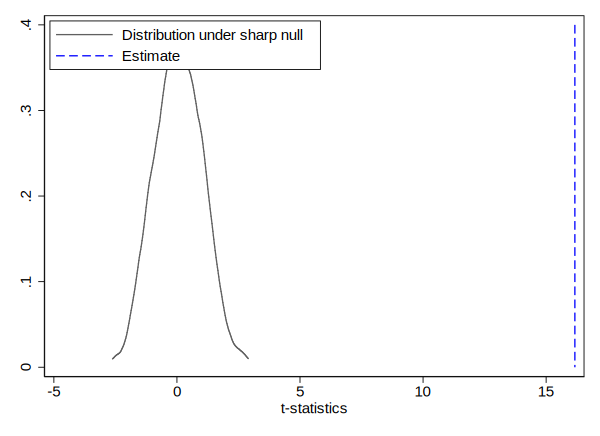

In [9]:
// Visualizing result
preserve
qui drop _all 
qui svmat T0, names(tstat)
twoway (kdensity tstat) ///
    (scatteri 0.4 $tstat 0 $tstat, recast(line) lcolor(blue) lpattern(dash)) ///
    , /// xline($tstat, lcolor(blue))  ///
    xtitle("t-statistics") /// xscale(range($tstat)) /// 
    legend(order(1 "Distribution under sharp null" 2 "Estimate") cols(1) position(11) ring(0))
restore

## Calculate CI

###  The first thing we need is a language to describe the dgp and (add or) subtract a treatment effect.

The command `impose_tx` does so, allowing us to describe the dgp using [Wilkinson-Rogers Notation](http://www.jerous.org/att/2016/05/11/wilkinson-rogers/wilkinson2formula.html).  Use the `subtract` option to take away the specified treatment effect from those treated (`treatment==1`); otherwise, default behavior will be to add it.  Specify a new variable (in the example below, `yprime`) to hold the generated variable.

This command will be used internally in the `ri_estimates` commmand, when a DGP and non-zero sharp null are requested, _first_ to subtract the hypothesized treatment effect off of the observed outcome, and _second_ to impose this treatment effect to create counterfactual observed outcomes under this hypothesis and alternative treatment assignments.

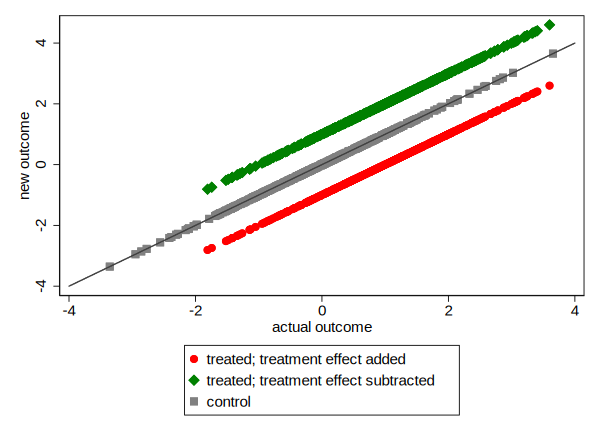

In [10]:
capture program drop impose_tx
capture drop yminus
capture drop yplus

//  Example where treatment effect is being subtracted
qui ge yminus = .
impose_tx , dgp(y ~ t_0) treatment(1) y(yminus) subtract

//  Example where treatment effect is being added
qui ge yplus = .
impose_tx, dgp(y ~ t_0) treatment(1) y(yplus)

tw (sc yminus y if t_0 == 1, mcolor(red)) ///
    (sc yplus y if t_0 == 1, mcolor(green)) ///
    (sc yminus y if t_0 == 0) ///
    (function y=x , range(-4 4)) /// (line y y, sort) ///
    , legend(order(1 "treated; treatment effect added" 2 "treated; treatment effect subtracted" 3 "control") cols(1)) ///
    ytitle("new outcome") xtitle("actual outcome")

### The second thing we need is the ability to conduct RI for non-sharp nulls.

This requires the ability to specify the data-generating process---which should be distinct from the estimator that delivers the test statistic---for randomization inference, in `ri_estimates()`.

In [11]:
capture program drop ri_estimates
ri_estimates, permutations($R) t1(t , filename(`T0') key(i))  dgp(y ~ t) treatmenteffect(1) /// imposing the *true* DGP
    teststat(t) pvalues values($tstat) /// using previously estimated t-statistic to compute a p-value for this sharp null.
    : regress y t
mat li r(RESULTS) // show p-value 
mat T0alt = r(T0)  // capture distribution of test statistic under sharp null.





symmetric r(RESULTS)[1,1]
      p
t  .516



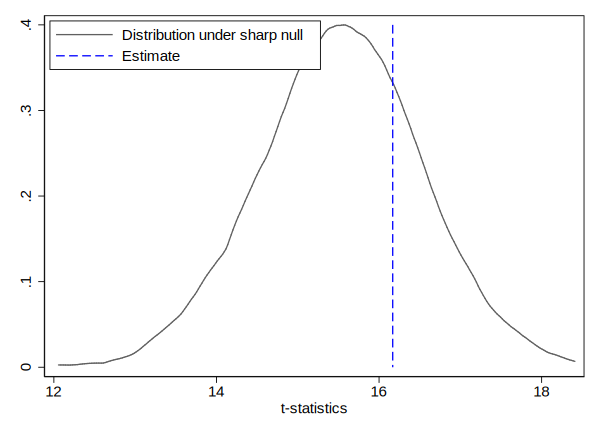

In [12]:
// Visualizing result
preserve
drop _all 
qui svmat T0alt, names(tstat)
twoway (kdensity tstat) ///
    (scatteri 0.4 $tstat 0 $tstat, recast(line) lcolor(blue) lpattern(dash)) ///
    , /// xline($tstat, lcolor(blue))  ///
    xtitle("t-statistics") /// xscale(range($tstat)) /// 
    legend(order(1 "Distribution under sharp null" 2 "Estimate") cols(1) position(11) ring(0))
restore

###  The third thing we need is a search process to arrive at an estimated 95% CI.

This involves a few key decisions, which will be programmed in the wrapper function `ri_ci`, which uses `impute_tx` and `ri_estimates` as defined above.

**Choose starting values**.  Looking ahead to the possibility of test statistics that are not based on regression, but (for now) assuming the DGP is always  a linear model, one possibility would be to use the analytical standard errors on a linear regression that corresponds to the DGP as a starting point.  

-  One option is just to let the user specify a starting value (actually, one for each endpoint).  Let's program this option first, since it seems easiest. 
-  When the test statistic is derived from a linear model, can use analytical SE
-  When the DGP is specified as a linear model, can estimate it via OLS and then use analytical SE.

**Define a stopping rule**.  How should the stopping rule be defined?  
- Fixed number of trial values (safe starting point)
- (User-specified) step distance;
- Something else?

_Demonstration using user-specified starting values and fixed number of trial values_.

Let global variable `$numTrials` hold the number of trial values to be evaluated for each of the upper and lower boundaries of the confidence interval.

In [13]:
global numTrials = 10 // number of trials to run

In [14]:
//  demo the ri_ci command.
capture program drop ri_ci
ri_ci, numtrials($numTrials) permutations($R) ///
    t1(t, filename(`T0') key(i) ) ///
    teststat(t) ///
    dgp(y ~ t ) ///
    ci0( 5 -5) checkboundary ///
    : reg y t // estimation command delivering the test statistic.

mat TRIALS_UB = r(TRIALS_UB)
mat TRIALS_LB = r(TRIALS_LB)
ret li




      Source |       SS           df       MS      Number of obs   =     1,000
-------------+----------------------------------   F(1, 998)       =    261.41
       Model |  272.464062         1  272.464062   Prob > F        =    0.0000
    Residual |  1040.19907       998  1.04228363   R-squared       =    0.2076
-------------+----------------------------------   Adj R-squared   =    0.2068
       Total |  1312.66313       999   1.3139771   Root MSE        =    1.0209

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           t |   1.044171   .0645818    16.17   0.000     .9174391    1.170902
       _cons |  -.0075103   .0452072    -0.17   0.868    -.0962224    .0812018
------------------------------------------------------------------------------
The test statistic for variable t is 16.16819930

In [15]:
di "Trial results in search for upper bound:"
mat li TRIALS_UB
di "Trial results in search for lower bound:"
mat li TRIALS_LB 


Trial results in search for upper bound:


TRIALS_UB[10,3]
            tau0  permutations        pvalue
r1             5           500             0
r1     3.0220853           500             0
r1      2.033128           500             0
r1     1.5386493           500             0
r1       1.29141           500             0
r1     1.1677903           500           .06
r1     1.2296002           500          .008
r1     1.1986952           500           .02
r1     1.1832428           500          .028
r1      1.190969           500          .024

Trial results in search for lower bound:


TRIALS_LB[10,3]
            tau0  permutations        pvalue
r1            -5           500             0
r1    -1.9779147           500             0
r1    -.46687201           500             0
r1     .28864933           500             0
r1     .66640999           500             0
r1     .85529033           500             0
r1     .94973049           500           .14
r1     .90251041         





number of observations will be reset to 10
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 10

file C:\Users\az332\AppData\Local\Temp\ST_3c48_000006.tmp saved


number of observations will be reset to 10
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 10


(analytic weights assumed)
(analytic weights assumed)
(analytic weights assumed)


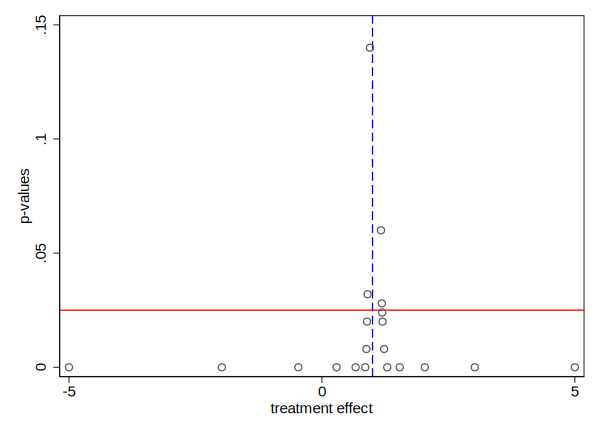

In [16]:
//  Visualize results
preserve
clear 
tempfile trials 
svmat TRIALS_UB, names(col)
save `trials' 

clear 
svmat TRIALS_LB, names(col)
append using `trials'

tw sc pvalue tau0 [w=permutations] ///
    , msymbol(oh) ///
    yline(0.025, lcolor(red)) ytitle("p-values") ///
    xline(1, lcolor(blue) lpattern(dash)) xtitle("treatment effect") ///

restore 

_Illustrating case with analytical standard errors used to determine search range._

In [17]:
capture drop t_*
capture program drop ri_ci
ri_ci, numtrials($numTrials) permutations($R) ///
    t1(t, filename(`T0') key(i) ) ///
    teststat(t) ///
    dgp(y ~ t ) ///
    analytic_initial checkboundary /// ci0( 10 -10) /// noci ///
    /// pzero /// <- to report p-value for zero null
    : reg y t // estimation command delivering the test statistic.
ret list 
mat TRIALS_UB = r(TRIALS_UB)
mat TRIALS_LB = r(TRIALS_LB)

di "Trial results in search for upper bound:"
mat li TRIALS_UB
di "Trial results in search for lower bound:"
mat li TRIALS_LB 





      Source |       SS           df       MS      Number of obs   =     1,000
-------------+----------------------------------   F(1, 998)       =    261.41
       Model |  272.464062         1  272.464062   Prob > F        =    0.0000
    Residual |  1040.19907       998  1.04228363   R-squared       =    0.2076
-------------+----------------------------------   Adj R-squared   =    0.2068
       Total |  1312.66313       999   1.3139771   Root MSE        =    1.0209

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           t |   1.044171   .0645818    16.17   0.000     .9174391    1.170902
       _cons |  -.0075103   .0452072    -0.17   0.868    -.0962224    .0812018
------------------------------------------------------------------------------
The test statistic for variable t is 16.1681993





number of observations will be reset to 10
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 10

file C:\Users\az332\AppData\Local\Temp\ST_3c48_000008.tmp saved


number of observations will be reset to 10
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 10


(analytic weights assumed)
(analytic weights assumed)
(analytic weights assumed)


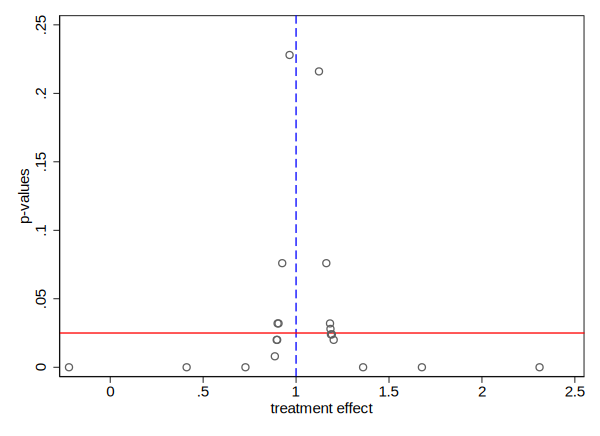

In [18]:
preserve
clear 
tempfile trials 
svmat TRIALS_UB, names(col)
save `trials' 

clear 
svmat TRIALS_LB, names(col)
append using `trials'

tw sc pvalue tau0 [w=permutations] ///
    , msymbol(oh) ///
    yline(0.025, lcolor(red)) ytitle("p-values") ///
    xline(1, lcolor(blue) lpattern(dash)) xtitle("treatment effect") ///

restore 
